In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import functions

In [2]:
months_list = ['October 2019', 'November 2019']
csv_list = ['../../archive/2019-Oct.csv', '../../archive/2019-Nov.csv']
df_list = []

for filename in csv_list:
    df_list.append(pd.read_csv(filename, header='infer').dropna())

df = pd.concat(df_list)

## Question RQ2 - 1

- What are the categories of the most trending products overall? For each month visualize this information through a plot showing the number of sold products per category

We iterate over all the datasets contained in df_list. Each element corresponds to a given month.
For each dataset, we filter only the rows reporting the sale of a product (the "purchase" event). Then, we group all elements by category, and count the event types (that are now only the purchases). Eventually, we plot each month't sales per product.

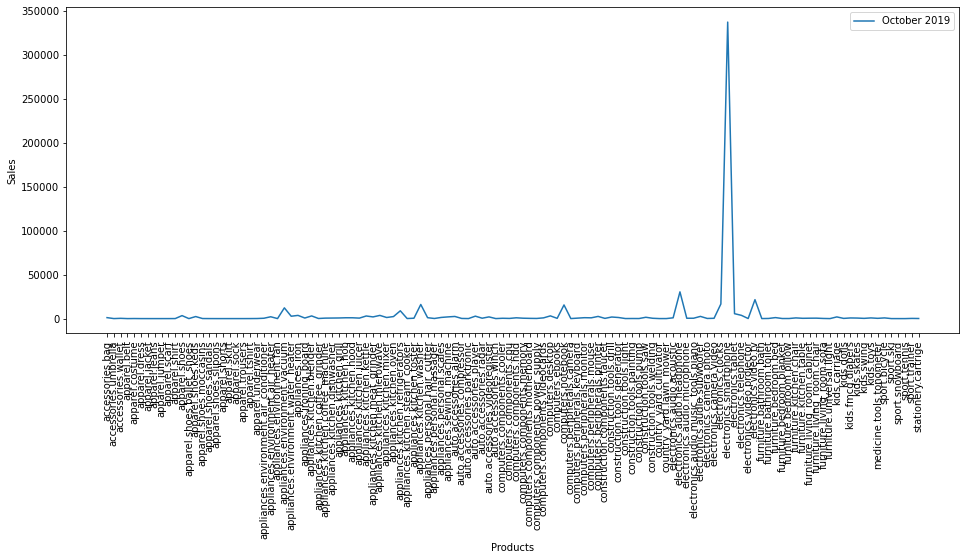

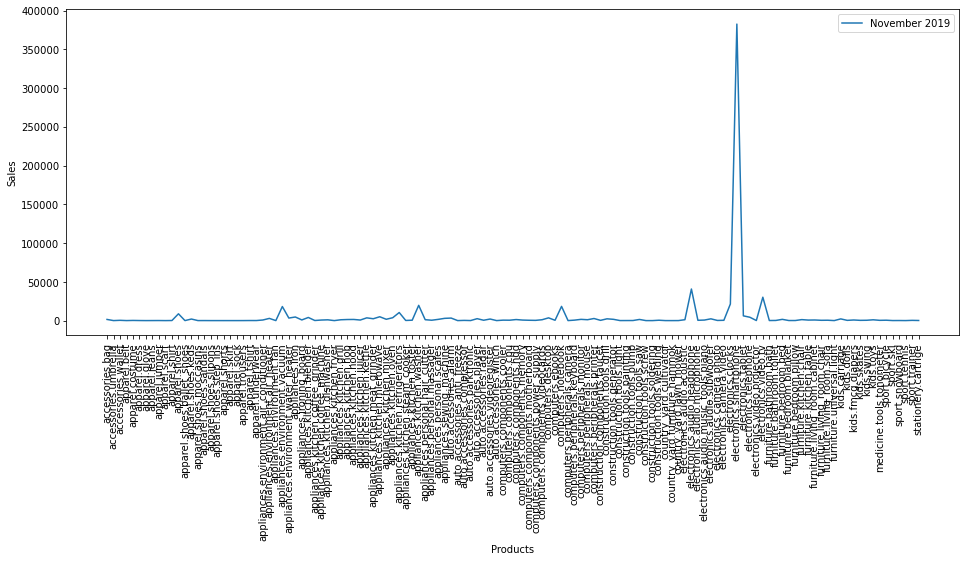

In [3]:
for i in range(len(df_list)):
    dd = df_list[i][df_list[i].event_type=='purchase'].groupby(['category_code']).event_type.count()
    
    plt.figure(figsize=(16,6))
    plt.plot(dd)
    plt.xticks(rotation='vertical')
    plt.xlabel('Products')
    plt.ylabel('Sales')
    plt.legend((months_list[i],))
    plt.show()

## Question RQ2 - 2

- Plot the most visited subcategories

In this case, we refer to the entire dataset of all months. We filter the dataset to get only the events where the user has 'viewed' a product, we select the 'category_code' column and split it into subcategories. If children subcategories are found, we take the first child as our target, otherwise the parent is taken. We group the data based on our target category/subcategory by means of the "Counter" library. Eventually, we plot the result.

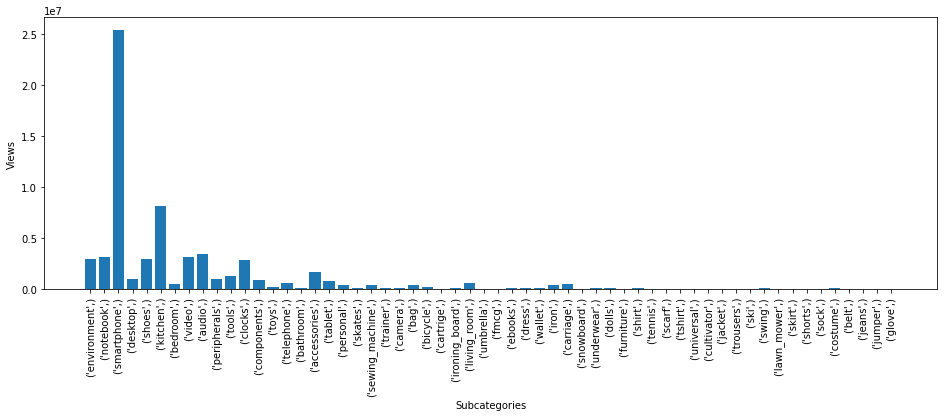

In [4]:
df_views = df[df.event_type=='view'].category_code
subcategories = df_views.apply(lambda x: x.split('.')[1] if len(x.split('.')) > 1 else x.split('.')[0])
count = Counter(list(zip(subcategories)))

plt.figure(figsize=[16,5])
plt.xticks(range(len(count)), labels=count.keys(), rotation='vertical')
plt.xlabel('Subcategories')
plt.ylabel('Views')
plt.bar(range(len(count)), count.values())
plt.show()

## Question RQ2 - 3

- What are the 10 most sold products per category?

From the dataset, we take the columns we need (event_type and category_code), we extract the events where the user has 'purchased' a product. Then, we sort the values by "sales" in descending order, and eventually print to screen the first 10 results.

In [5]:
groups = df[['event_type','category_code']][df.event_type=='purchase'].groupby(['category_code'])
result = groups[['event_type']].count().sort_values(by=['event_type'],ascending=False).head(10)

result

event_type
category_code                               
electronics.smartphone                720067
electronics.audio.headphone            71181
electronics.video.tv                   51726
electronics.clocks                     38073
appliances.kitchen.washer              35739
computers.notebook                     33870
appliances.environment.vacuum          30340
appliances.kitchen.refrigerators       19291
apparel.shoes                          12166
electronics.tablet                     11722

## Question RQ6 - 1

- What's the conversion rate of your online store? Find the overall conversion rate of your store.

After grouping the dataset by product_id and event_type, we create two variables: the total number of purchases (n_purchase) and the total number of views (n_views).
We output the conversion rate of the store as the ratio between the total number of purchases and the total number of views.

In [6]:
groups = df.groupby(['category_code','event_type'])

n_purchase = groups.filter(lambda x: (x['event_type'] == 'purchase').any() ).event_type.count()
n_views = groups.filter(lambda x: (x['event_type'] == 'view').any() ).event_type.count()

conversion_rate = n_purchase / n_views

conversion_rate

0.01873559331680558

## Question RQ6 - 2

- Plot the number of purchases of each category

Same question as RQ2 - 1

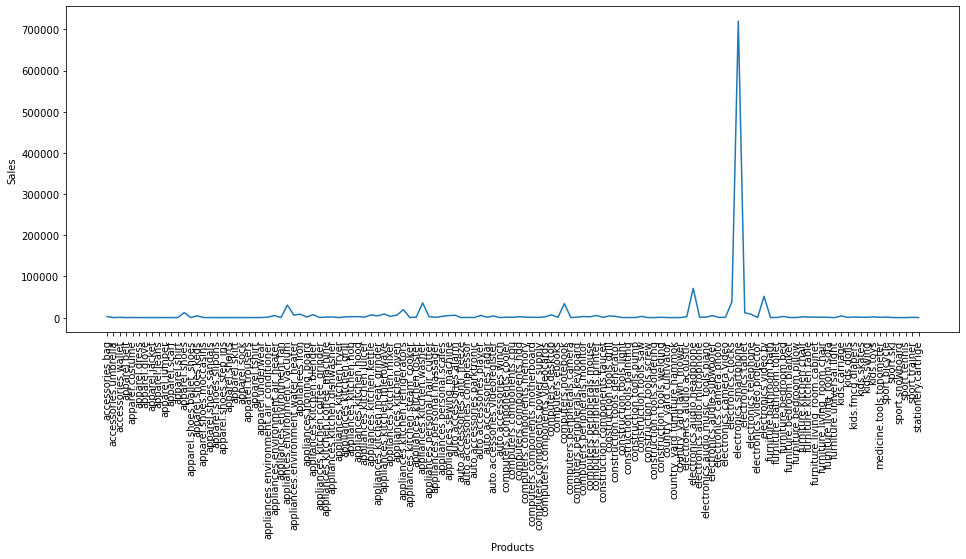

In [7]:
n_purchase = df[df.event_type=="purchase"].groupby(['category_code']).event_type.count()

plt.figure(figsize=(16,6))
plt.plot(n_purchase)
plt.xticks(rotation='vertical')
plt.xlabel('Products')
plt.ylabel('Sales')
plt.show()

## Question RQ6 - 3

- Show the conversion rate of each category in decreasing order

We first remove from the dataset the event_type "cart", which is not useful. After that, we groupby the columns "category_code" and "event_type", and then count the number of times each "event_type" is repeated per product. The result is stored in a dictionary "d". We iterate through "d" to generate the "products" and "conversion_rates" elements of the list "k", that are needed to plot the requested function. The intermediate dictionary "g" is created to help keeping track of the progress of the iterations over "d".
The dictionary "k" is sorted in descending order relatively to its values (the conversion rates), and its elements are associated to x (products) and y (conversion rates).
The variables "x" and "y" are finally used to plot the result.

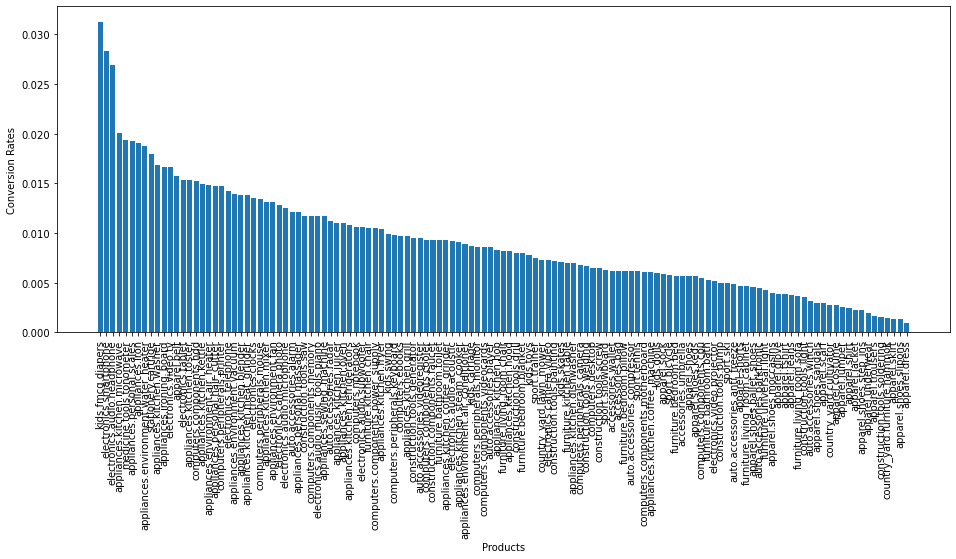

In [8]:
d = df[df.event_type!="cart"].groupby(['category_code','event_type']).event_type.apply(lambda x: x.count()).sort_values(ascending=False).to_dict()

g = {}
k = {}

for key in d:
    if key[0] in g:
        g[key[0]][key[1]] = d[key]
        
        cr = round(g[key[0]]['purchase'] / g[key[0]]['view'], 5)
        k[key[0]] = cr
    else:
        g[key[0]] = {}
        g[key[0]][key[1]] = d[key]

x, y = zip(*sorted(k.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(16,6))
plt.bar(x, y)
plt.xticks(rotation='vertical')
plt.xlabel('Products')
plt.ylabel('Conversion Rates')
plt.show()

## Question RQ7 - 1

- Prove that the pareto principle applies to your store

We first create a dataset named "customers" by filtering all the purchases made on our store. We then group the result into several groups, each one containing all the purchases made by each user. We then calculate the income made per user by means of the "price" column, and save the result in descending order. We now have a list of all the users according to how much they spent on our store.

With such information, it is now possible to create two different subsets: the first one containing the 20% of the customers that have spent the most (sales_20), and the second one with the remaining 80% (sales_80).

At this point, we can observe that 70% of the money we earned during the given observation period are only coming from 20% our customers. This result is very close to the one suggested by the Pareto principle, hence confirming the 80/20 rule.

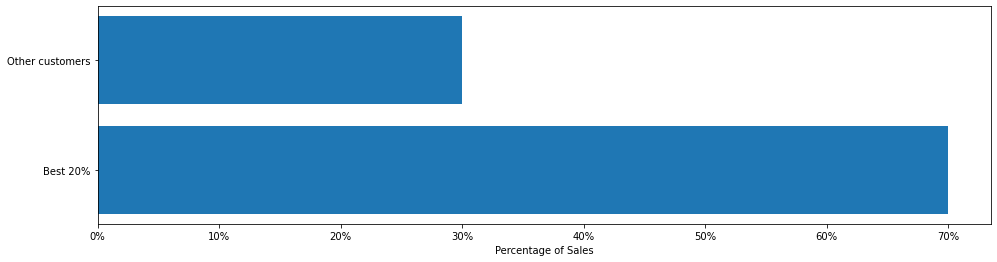

In [9]:
customers = df[df.event_type=="purchase"].groupby(['user_id'])
customers_by_sales = customers.price.sum().reset_index().sort_values('price', ascending=False)

n = int(len(customers_by_sales)*(1/5))
m = len(customers_by_sales) - n

sales_20 = customers_by_sales.head(n)
sales_80 = customers_by_sales.tail(m)

ratio_20 = sales_20.price.sum() / customers_by_sales.price.sum()
ratio_80 = sales_80.price.sum() / customers_by_sales.price.sum()

data = [ratio_20, ratio_80]
ticks = ['Best 20%', 'Other customers']

plt.figure(figsize=(16,4))
plt.barh([1,2], data)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.yticks([1,2],ticks)
plt.xlabel('Percentage of Sales')
plt.show()